# Introduction

This code accompanies the paper [Model Transferability with Responsive Decision Subjects](https://arxiv.org/pdf/2107.05911.pdf) accepted by ICML 2023.

In particular, it generates Figure 4 of the paper about the synthetic experiements using simulated data. 

# Import Libraries 

In [1]:
import numpy as np
import random as random
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
import matplotlib.pyplot as plt

# Covariate Shift

## helper functions

#### generate the initial data distribution

In [2]:
def generate_init_CS(N, sigma2, sigma3):
    '''
    generate the initial dataframe for covariate shift
    
    Input:
        - N: total nunber of samples
        - sigma2: variance of the noisy term for X2
        - sigma3: variance of the noisy term for X3
    
    N: total number of points
    X1 ~ unif(-1, 1)
    X2 ~ 1.2X1 + N(0,sigma2)
    X3 ~ -0.8X1^2 + N(0,sigma3)
    Y is threshold based on the value of X2
    
    output:
        - df: a data frame df with ['X1', 'X2', 'X3', 'Y']
    '''
    random_seed = random.randint(1, 1000)
    np.random.seed(random_seed)

    # generate X1, X2, X3
    X1 = np.random.uniform(-1, 1, N)
    X2 = X1 * 1.2 + np.random.normal(0, sigma2, N)
    X3 = -X1**2 * 0.8 + np.random.normal(0, sigma3, N)
    # Generate Y
    Y = 1 * (X2 > 0)
    d = {'X1': list(X1), 'X2': list(X2), 'X3': list(X3), 'Y': list(Y)}
    df = pd.DataFrame(data=d)
    return df

#### Compute optimal threshold (hS) for the source distribution 

In [3]:
# helper function: compute average square error of a threshold on a dataframe df
def compute_error(df, threshold):
    '''
    Input: 
        - df: a dataset with a column for 'Q' already computed
        - a threshold
    
    output:
        - the mean squared error
    '''
    error = 0
    # compute error
    for i in range(len(df)):
        # if df_result["x"][i]'s value is greater than the treshold then h(x) = +1; otherwise h(x) = 0
        error = error + ((df.iloc[i]["Q"] > threshold) - df.iloc[i]["Y"])**2
    return error / len(df)


#### Compute the optimal threshold for the original distribution

In [4]:
def compute_optimal_threshold(df, M):
    '''
    A function to learn the optimal threshold on the original dataset 
    
    Input:
        - df: a dataset with a column for 'Q' already computed
        - M is the number of potential thresholds.
        
    Output:
        - the optimal threshold for df
    '''
    # compute the boundary of Q:
    Q_min, Q_max = np.min(df["Q"]), np.max(df["Q"])

    # loop through potential thresholds:
    error_list = []
    for i in range(M):
        threshold = Q_min + i * (Q_max - Q_min) / M
        error_list.append(compute_error(df, threshold))
    index_min = np.argmin(error_list)
    optimal_threshold = Q_min + index_min * (Q_max - Q_min) / M
    return optimal_threshold

#### Compute induced distribution given a threshold


In [5]:
# compute the induced distribution
def compute_new_distribution_CS(df, sigma2, sigma3, threshold, c):
    '''
    input:
        - df: original dataframe (without 'Q')
        - sigma2:
        - sigma3:
        - threshold: a given threshold
        - c: coefficient for adjusting the magnitude of distribution shift
    output:
        - the new dataframe for holding the induced distribution
    '''
    N = len(df)
    # compute the new data distribution
    # get the old classifier result
    hX = 1 * (df["Q"] > threshold)
    # hX = df["Q"]
    # generate new X1
    X1_new = df['X1'] + c * (2 * hX - 1)

    X2_new = X1_new * 1.2 + np.random.normal(0, sigma2, N)
    X3_new = -X1_new**2 * 0.8 + np.random.normal(0, sigma3, N)
    # Generate Y
    Y_new = 1 * (X2_new > 0)
    d = {
        'X1': list(X1_new),
        'X2': list(X2_new),
        'X3': list(X3_new),
        'Y': list(Y_new)
    }
    df_new = pd.DataFrame(data=d)
    return df_new

#### Compute optimal classifier achieve minimum induced risk

In [6]:
def compute_optimal_threshold_MinInduceRisk_CS(df, sigma2, sigma3, M, c):
    '''
    find the optimal classifier achieve min Err(h)(h)
    
    input:
        -  df: original dataframe (without 'Q')
        -  M: number of potential classifiers to search for
        -  c: coefficient for adjusting the magnitude of distribution shift
        
    output: 
        -  optimal threshold  = argmin Err(h)(h)
        -  the minimum error 
    '''
    N = len(df)

    # compute the coefficients on the initial data distribution
    clf_CS = LogisticRegression(solver='liblinear', fit_intercept=True)
    clf_CS.fit(df[["X1", "X2", "X3"]], df['Y'])

    # compute the boundary of Q:
    Q_min, Q_max = np.min(df["Q"]), np.max(df["Q"])

    # loop through the potential thresholds
    error_list = []
    for j in range(M):
        threshold = Q_min + j * (Q_max - Q_min) / M
        # compute the new data distribution
        df_new = compute_new_distribution_CS(df, sigma2, sigma3, threshold, c)
        # compute the new qualification
        # using the coefficient from the logistic regression coefficient for the old dataset
        df_new['Q'] = clf_CS.predict_proba(df_new[["X1", "X2", "X3"]])[:, 1]
        # compute new data distribution's loss
        Err_h_h = compute_error(df_new, threshold)
        error_list.append(Err_h_h)
    index_min = np.argmin(error_list)
    min_error = np.min(error_list)

    # compute the optimal threshold on the dataset that it induced call it hT
    optimal_threshold = Q_min + index_min * (Q_max - Q_min) / M
    return optimal_threshold, min_error

#### compute varaince of coefficients between two dataset

In [7]:
# compute the variance of w_h for two distribution
def var_w(df, df_new, number_bin):
    '''
    Give two dataframe, compute w(x) = Pr_{df_new}(x)/Pr_{df}(x)
    
    Input:
        - df: one dataframe
        - df_new: another dataframe
        - number_bin: # of bins
    Output:
        - w(x)
    
    '''
    bin_init, _ = np.histogram(np.array(df[['X1', 'X2', 'X3']]),
                               bins=number_bin)
    bin_new, _ = np.histogram(np.array(df_new[['X1', 'X2', 'X3']]),
                              bins=number_bin)

    return np.var(bin_init / bin_new)

## Upper bounds for covariate shift

Covariate Shift Upper Bound is (Theorem 4.2 in Section 4.1):

          Err(hS)(hS) - Err(hT)(hT) <= \sqrt{Err(DS)(hT)} (\sqrt{Var(w(hS))} + \sqrt{Var(w(hT))})

To characterize the CS upper bound, we need to compute the following quantities:
  -  hS (optimal classifier trained on the original dataset)
  
  -  Err_hs_hs (error of hS on the distribution it induces D(hS)
  
  -  hT (optimal classifier considering induced data distribution)
  
  -  Err_hT_hT (error of hT on the distribution it induced D(hT))
  
  -  Err_S_hT (error of hT on the source distribution S)
  
  -  sqrt(var(whS))+sqrt(var(whT)): where whS and whT are the varaince of w(hS) and w(hT)


#### Set Parameters

In [8]:
N = 500
c = 0.5
M = 100
sigma2 = 0.15
sigma3 = 0.1

number_bin = 20

In [9]:
# generate the initial data distribution
df_init_CS = generate_init_CS(N, sigma2, sigma3)

#### Train a logistic regression classifier based on the initial dataframe

In [10]:
clf_CS = LogisticRegression(solver='liblinear', fit_intercept=True)
clf_CS.fit(df_init_CS[["X1", "X2", "X3"]], df_init_CS['Y'])

LogisticRegression(solver='liblinear')

In [11]:
# compute the "qualification" (linear combination of features) based on the logistic regression model we trained
df_init_CS['Q'] = clf_CS.predict_proba(df_init_CS[["X1", "X2", "X3"]])[:, 1]

#### compute hS

In [12]:
# compute the optimal threshold on the original dataset, name it "hS_CS"
hS_CS = compute_optimal_threshold(df_init_CS, M)
print("hS:", hS_CS)

# error on the original dataset S using classifier hS_CS
Err_S_hS_CS = compute_error(df_init_CS, hS_CS)
print("Err_S_hS_CS:", Err_S_hS_CS)


hS: 0.4799997742308634
Err_S_hS_CS: 0.016


In [13]:
# compute the induced data distribution by hS call it df_hS_CS
df_hS_CS = compute_new_distribution_CS(df_init_CS, sigma2, sigma3, hS_CS, c)

# compute the new qualification
df_hS_CS['Q'] = clf_CS.predict_proba(df_hS_CS[["X1", "X2", "X3"]])[:, 1]
# compute the error on the induced dataset using hS, call it Err_hS_hS_LS
Err_hS_hS_CS = compute_error(df_hS_CS, hS_CS)
print("Err_hS_hS_CS:", Err_hS_hS_CS)


Err_hS_hS_CS: 0.0


In [14]:
# compute the optimal classifier "hT_CS" consider induced data and the corresponding induced error "Err_T_T_CS"
hT_CS, Err_hT_hT_CS = compute_optimal_threshold_MinInduceRisk_CS(
    df_init_CS, sigma2, sigma3, M, c)

print("hT_CS:", hT_CS)
print("Err_hT_hT_CS:", Err_hT_hT_CS)

# compute the new data distribution induced by hT
df_hT_CS = compute_new_distribution_CS(df_init_CS, sigma2, sigma3, hT_CS, c)
df_hT_CS['Q'] = clf_CS.predict_proba(df_hT_CS[["X1", "X2", "X3"]])[:, 1]


hT_CS: 0.1000177771502435
Err_hT_hT_CS: 0.0


In [15]:
# compute Err_S_hT
Err_S_hT_CS = compute_error(df_init_CS, hT_CS)
print("Err_S_hT_CS", Err_S_hT_CS)

Err_S_hT_CS 0.106


Text(0.5, 1.0, 'Y vs Q for D(hT)')

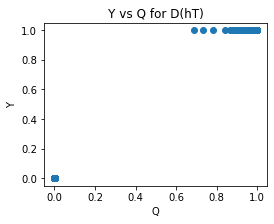

In [16]:
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(df_hT_CS["Q"], df_hT_CS["Y"])
plt.ylabel("Y")
plt.xlabel("Q")
plt.title("Y vs Q for D(hT)")

In [17]:
var_whs_CS = var_w(df_init_CS, df_hS_CS, number_bin=number_bin)
print(var_whs_CS)


812.0903515802157


In [18]:
var_whT_CS = var_w(df_init_CS, df_hT_CS, number_bin=number_bin)
print(var_whT_CS)

2.701092303189744


### Compute the upper bound

In [19]:
# compute Err_hs_hs - Err_hT_hT
print("Err_hs_hs_CS - Err_hT_hT_CS:", Err_hS_hS_CS - Err_hT_hT_CS)

# compute Err_S_hT
Err_S_hT_CS = compute_error(df_init_CS, hT_CS)
#print("Err_S_hT_CS", Err_S_hT_CS)

# compute the upper bound (theorem 5)
UB = np.sqrt(Err_S_hT_CS) * (np.sqrt(var_whs_CS) + np.sqrt(var_whT_CS))
print("the upper bound is:", UB)

Err_hs_hs_CS - Err_hT_hT_CS: 0.0
the upper bound is: 9.813100642705699


## lower bound for covariate shift

Covariate Shift lower bound is (Theorem 4.6 in Section 4.2):

                max{Err_S(h), Err_h(h)} >= (dTV(D_S(Y), D_h(Y)) - dTV(D_S(h), D_h(h)))/2


To test the lower bound, we need to compute the following quantities for hS and hT:

   - max{Err_S(h), Err_h(h)} 
   
        
   - dTV(D_S(Y), D_h(Y)) = |Pr_S(Y = 1) - Pr_h(Y = 1)|
   
    
   - dTV(D_S(h), D_h(h)) = |Pr_S(h = 1) - Pr_h(h = 1)|

#### compute the lower bound for hT (theorem 4.6)

In [20]:
# compute Pr_Ds[Y = +1]
Pr_S_Y1_CS = df_init_CS['Y'].value_counts()[1] / len(df_init_CS)

#print("Pr_S_Y1_CS", Pr_S_Y1_CS)

# compute Pr_DhT[Y = +1]
Pr_hT_Y1_CS = df_hT_CS['Y'].value_counts()[1] / len(df_hT_CS)

#print("Pr_Dh_Y1_CS", Pr_Dh_Y1_CS)

# compute Pr_Ds[hT(X) = +1]
Pr_S_hT1_CS = np.sum(df_init_CS['Q'] > hT_CS) / len(df_init_CS)

# compute Pr_DhT[hT(X) = +1]
Pr_hT_hT1_CS = np.sum(df_hT_CS['Q'] > hT_CS) / len(df_hT_CS)

#print("Pr_hT_hT1_CS", Pr_hT_hT1_CS)

print("max{Err_S(hT), Err_hT(hT)}", max(Err_S_hT_CS, Err_hT_hT_CS))

LB_hT_CS = (np.abs(Pr_S_Y1_CS - Pr_hT_Y1_CS) -
            np.abs(Pr_S_hT1_CS - Pr_hT_hT1_CS)) / 2
print("the lower bound for using hT is:", LB_hT_CS)

max{Err_S(hT), Err_hT(hT)} 0.106
the lower bound for using hT is: 0.05299999999999999


#### compute the lower bound for hS (theorem 4.6)

In [21]:
# compute Pr_DS[Y = +1]
Pr_S_Y1_CS = df_init_CS['Y'].value_counts()[1] / len(df_init_CS)

# compute Pr_DhS[Y = +1]
Pr_hS_Y1_CS = df_hS_CS['Y'].value_counts()[1] / len(df_hS_CS)

# compute Pr_DS[hS(X) = +1]
Pr_S_hS1_CS = np.sum(df_init_CS['Q'] > hS_CS) / len(df_init_CS)

# compute Pr_DhS[hS(X) = +1]
Pr_hS_hS1_CS = np.sum(df_hS_CS['Q'] > hS_CS) / len(df_hS_CS)

print("max{Err_S(hS), Err_hS(hS)}", max(Err_S_hS_CS, Err_hS_hS_CS))

LB_hS_CS = (np.abs(Pr_S_Y1_CS - Pr_hS_Y1_CS) -
            np.abs(Pr_S_hS1_CS - Pr_hS_hS1_CS)) / 2
print("the lower bound for using hS is:", LB_hS_CS)

max{Err_S(hS), Err_hS(hS)} 0.016
the lower bound for using hS is: 0.0040000000000000036



### A helper function for computing upper and lower bound for one particular dataset

In [22]:
def compute_upper_lower_bound_CS(N=1000,
                                 c=0.25,
                                 M=100,
                                 sigma2=0.15,
                                 sigma3=0.1,
                                 number_bin=20):
    '''
    A helper function that takes in all the parameters and compute the upper bounds
    '''

    # generate the initial data distribution
    df_init_CS = generate_init_CS(N, sigma2, sigma3)

    # #### Train a logistic regression classifier based on the initial dataframe
    clf_CS = LogisticRegression(solver='liblinear', fit_intercept=True)
    clf_CS.fit(df_init_CS[["X1", "X2", "X3"]], df_init_CS['Y'])

    # compute the "qualification" (linear combination of features) based on the logistic regression model we trained
    df_init_CS['Q'] = clf_CS.predict_proba(df_init_CS[["X1", "X2", "X3"]])[:,
                                                                           1]

    #compute hS

    # compute the optimal threshold on the original dataset, name it "hS_CS"
    hS_CS = compute_optimal_threshold(df_init_CS, M)
    #     print("hS:", hS_CS)

    # error on the original dataset S using classifier hS_CS
    Err_S_hS_CS = compute_error(df_init_CS, hS_CS)
    #     print("Err_S_hS_CS:", Err_S_hS_CS)

    # compute the induced data distribution by hS call it df_hS_CS
    df_hS_CS = compute_new_distribution_CS(df_init_CS, sigma2, sigma3, hS_CS,
                                           c)

    # compute the new qualification
    df_hS_CS['Q'] = clf_CS.predict_proba(df_hS_CS[["X1", "X2", "X3"]])[:, 1]
    # compute the error on the induced dataset using hS, call it Err_hS_hS_LS
    Err_hS_hS_CS = compute_error(df_hS_CS, hS_CS)
    #     print("Err_hS_hS_CS:", Err_hS_hS_CS)

    # compute the optimal classifier "hT_CS" consider induced data and the corresponding induced error "Err_T_T_CS"
    hT_CS, Err_hT_hT_CS = compute_optimal_threshold_MinInduceRisk_CS(
        df_init_CS, sigma2, sigma3, M, c)

    #     print("hT_CS:", hT_CS)
    #     print("Err_hT_hT_CS:",Err_hT_hT_CS)

    # compute the new data distribution induced by hT
    df_hT_CS = compute_new_distribution_CS(df_init_CS, sigma2, sigma3, hT_CS,
                                           c)
    df_hT_CS['Q'] = clf_CS.predict_proba(df_hT_CS[["X1", "X2", "X3"]])[:, 1]

    # compute Err_S_hT
    Err_S_hT_CS = compute_error(df_init_CS, hT_CS)
    #     print("Err_S_hT_CS", Err_S_hT_CS)

    var_whs_CS = var_w(df_init_CS, df_hS_CS, number_bin=number_bin)
    #     print(var_whs_CS)

    var_whT_CS = var_w(df_init_CS, df_hT_CS, number_bin=number_bin)
    #     print(var_whT_CS)

    # compute Err_hs_hs - Err_hT_hT
    print("Err_hs_hs_CS - Err_hT_hT_CS:", Err_hS_hS_CS - Err_hT_hT_CS)

    # compute Err_S_hT
    Err_S_hT_CS = compute_error(df_init_CS, hT_CS)
    #print("Err_S_hT_CS", Err_S_hT_CS)

    # compute the upper bound (theorem 5)
    UB = np.sqrt(Err_S_hT_CS) * (np.sqrt(var_whs_CS) + np.sqrt(var_whT_CS))
    print("the upper bound is:", UB)

    # compute Pr_Ds[Y = +1]
    Pr_S_Y1_CS = df_init_CS['Y'].value_counts()[1] / len(df_init_CS)

    #print("Pr_S_Y1_CS", Pr_S_Y1_CS)

    # compute Pr_DhT[Y = +1]
    Pr_hT_Y1_CS = df_hT_CS['Y'].value_counts()[1] / len(df_hT_CS)

    #print("Pr_Dh_Y1_CS", Pr_Dh_Y1_CS)

    # compute Pr_Ds[hT(X) = +1]
    Pr_S_hT1_CS = np.sum(df_init_CS['Q'] > hT_CS) / len(df_init_CS)

    # compute Pr_DhT[hT(X) = +1]
    Pr_hT_hT1_CS = np.sum(df_hT_CS['Q'] > hT_CS) / len(df_hT_CS)

    #print("Pr_hT_hT1_CS", Pr_hT_hT1_CS)

    print("max{Err_S(hT), Err_hT(hT)}", max(Err_S_hT_CS, Err_hT_hT_CS))

    LB_hT_CS = (np.abs(Pr_S_Y1_CS - Pr_hT_Y1_CS) -
                np.abs(Pr_S_hT1_CS - Pr_hT_hT1_CS)) / 2
    print("the lower bound for using hT is:", LB_hT_CS)

    # compute Pr_DS[Y = +1]
    Pr_S_Y1_CS = df_init_CS['Y'].value_counts()[1] / len(df_init_CS)

    # compute Pr_DhS[Y = +1]
    Pr_hS_Y1_CS = df_hS_CS['Y'].value_counts()[1] / len(df_hS_CS)

    # compute Pr_DS[hS(X) = +1]
    Pr_S_hS1_CS = np.sum(df_init_CS['Q'] > hS_CS) / len(df_init_CS)

    # compute Pr_DhS[hS(X) = +1]
    Pr_hS_hS1_CS = np.sum(df_hS_CS['Q'] > hS_CS) / len(df_hS_CS)

    print("max{Err_S(hS), Err_hS(hS)}", max(Err_S_hS_CS, Err_hS_hS_CS))

    LB_hS_CS = (np.abs(Pr_S_Y1_CS - Pr_hS_Y1_CS) -
                np.abs(Pr_S_hS1_CS - Pr_hS_hS1_CS)) / 2
    print("the lower bound for using hS is:", LB_hS_CS)

    return Err_hS_hS_CS - Err_hT_hT_CS, UB, max(Err_S_hT_CS,
                                                Err_hT_hT_CS), LB_hT_CS, max(
                                                    Err_S_hS_CS,
                                                    Err_hS_hS_CS), LB_hS_CS


#### test the helper function with a particular setup

In [23]:
_, _, _, _, _, _ = compute_upper_lower_bound_CS(N=500,
                                                c=0.25,
                                                M=100,
                                                sigma2=0.15,
                                                sigma3=0.1,
                                                number_bin=20)


Err_hs_hs_CS - Err_hT_hT_CS: 0.006
the upper bound is: 0.47522785712216153
max{Err_S(hT), Err_hT(hT)} 0.046
the lower bound for using hT is: 0.01999999999999999
max{Err_S(hS), Err_hS(hS)} 0.012
the lower bound for using hS is: 0.007000000000000006


### Helper function to generate the average actual and theoretical upper and lower bound for covariate shift setting

In [24]:
def average_actual_theoretical_bounds_CS(num_datasets, N, c, M, sigma2, sigma3,
                                         number_bin):

    actual_UB_list_CS = []
    UB_list_CS = []

    actual_LB_hS_list_CS = []
    LB_hS_list_CS = []

    actual_LB_hT_list_CS = []
    LB_hT_list_CS = []

    for i in range(num_datasets):
        print(i)
        actual_UB, UB, actual_LB_hS, LB_hS, actual_LB_hT, LB_hT = compute_upper_lower_bound_CS(
            N, c, M, sigma2, sigma3, number_bin)

        actual_UB_list_CS.append(actual_UB)
        UB_list_CS.append(UB)

        actual_LB_hS_list_CS.append(actual_LB_hS)
        LB_hS_list_CS.append(LB_hS)

        actual_LB_hT_list_CS.append(actual_LB_hT)
        LB_hT_list_CS.append(LB_hT)

    # compute the mean and error bar for the actual upper bound
    actual_UB_CS_mean = np.mean(actual_UB_list_CS)

    actual_UB_CS_errormin = np.abs(
        np.min(actual_UB_list_CS) - actual_UB_CS_mean)
    actual_UB_CS_errormax = np.max(actual_UB_list_CS) - actual_UB_CS_mean

    actual_UB_CS_error = [actual_UB_CS_errormin, actual_UB_CS_errormax]

    # compute the mean and error bar for the theoretical upper bound

    UB_CS_mean = np.mean(UB_list_CS)

    UB_CS_errormin = np.abs(np.min(UB_list_CS) - UB_CS_mean)
    UB_CS_errormax = np.max(UB_list_CS) - UB_CS_mean

    UB_CS_error = [UB_CS_errormin, UB_CS_errormax]

    print("actual_UB_CS_mean:", actual_UB_CS_mean)
    print("UB_CS_mean:", UB_CS_mean)

    print("actual_UB_CS_error:", actual_UB_CS_error)
    print("UB_CS_error:", UB_CS_error)

    # for hS
    actual_LB_hS_CS_mean = np.mean(actual_LB_hS_list_CS)
    LB_hS_CS_mean = np.mean(LB_hS_list_CS)

    actual_LB_hS_CS_errormin = np.abs(
        np.min(actual_LB_hS_list_CS) - LB_hS_CS_mean)
    actual_LB_hS_CS_errormax = np.max(actual_LB_hS_list_CS) - LB_hS_CS_mean

    actual_LB_hS_CS_error = [
        actual_LB_hS_CS_errormin, actual_LB_hS_CS_errormax
    ]

    LB_CS_hS_errormin = np.abs(np.min(LB_hS_list_CS) - LB_hS_CS_mean)
    LB_CS_hS_errormax = np.max(LB_hS_list_CS) - LB_hS_CS_mean

    LB_hS_CS_error = [LB_CS_hS_errormin, LB_CS_hS_errormax]

    # for hT

    actual_LB_hT_CS_mean = np.mean(actual_LB_hT_list_CS)
    LB_hT_CS_mean = np.mean(LB_hT_list_CS)

    actual_LB_hT_CS_errormin = np.abs(
        np.min(actual_LB_hT_list_CS) - LB_hT_CS_mean)
    actual_LB_hT_CS_errormax = np.max(actual_LB_hT_list_CS) - LB_hT_CS_mean

    actual_LB_hT_CS_error = [
        actual_LB_hT_CS_errormin, actual_LB_hT_CS_errormax
    ]

    LB_CS_hT_errormin = np.abs(np.min(LB_hT_list_CS) - LB_hT_CS_mean)
    LB_CS_hT_errormax = np.max(LB_hT_list_CS) - LB_hT_CS_mean

    LB_hT_CS_error = [LB_CS_hT_errormin, LB_CS_hT_errormax]

    print("actual_LB_hS_CS_error", actual_LB_hS_CS_error)
    print("LB_hS_CS_error", LB_hS_CS_error)

    print("actual_LB_hT_CS_error", actual_LB_hT_CS_error)
    print("LB_hT_CS_error", LB_hT_CS_error)

    return actual_UB_CS_mean, actual_UB_CS_error, UB_CS_mean, UB_CS_error, actual_LB_hT_CS_mean, actual_LB_hT_CS_error, LB_hT_CS_mean, LB_hT_CS_error


#### generate the bounds for two particular datasets (CS1, CS2)

In [25]:
actual_UB_CS_mean, actual_UB_CS_error, UB_CS_mean, UB_CS_error, actual_LB_hT_CS_mean, actual_LB_hT_CS_error, LB_hT_CS_mean, LB_hT_CS_error = average_actual_theoretical_bounds_CS(
    num_datasets=5,
    N=500,
    c=0.25,
    M=100,
    sigma2=0.15,
    sigma3=0.1,
    number_bin=20)


0
Err_hs_hs_CS - Err_hT_hT_CS: 0.0
the upper bound is: 0.41458669896267475
max{Err_S(hT), Err_hT(hT)} 0.03
the lower bound for using hT is: 0.01200000000000001
max{Err_S(hS), Err_hS(hS)} 0.018
the lower bound for using hS is: 0.0010000000000000009
1
Err_hs_hs_CS - Err_hT_hT_CS: 0.002
the upper bound is: 0.32979601718672164
max{Err_S(hT), Err_hT(hT)} 0.032
the lower bound for using hT is: 0.014000000000000012
max{Err_S(hS), Err_hS(hS)} 0.004
the lower bound for using hS is: 0.0010000000000000009
2
Err_hs_hs_CS - Err_hT_hT_CS: 0.004
the upper bound is: 0.29035544218616854
max{Err_S(hT), Err_hT(hT)} 0.036
the lower bound for using hT is: 0.016000000000000014
max{Err_S(hS), Err_hS(hS)} 0.008
the lower bound for using hS is: 0.0020000000000000018
3
Err_hs_hs_CS - Err_hT_hT_CS: 0.0
the upper bound is: 0.2200196741280874
max{Err_S(hT), Err_hT(hT)} 0.034
the lower bound for using hT is: 0.012999999999999956
max{Err_S(hS), Err_hS(hS)} 0.006
the lower bound for using hS is: 0.0010000000000000009

In [26]:
actual_UB_CS_mean2, actual_UB_CS_error2, UB_CS_mean2, UB_CS_error2, actual_LB_hT_CS_mean2, actual_LB_hT_CS_error2, LB_hT_CS_mean2, LB_hT_CS_error2 = average_actual_theoretical_bounds_CS(
    num_datasets=5,
    N=800,
    c=0.45,
    M=100,
    sigma2=0.25,
    sigma3=0.1,
    number_bin=20)


0
Err_hs_hs_CS - Err_hT_hT_CS: 0.0025
the upper bound is: 0.5852547642534905
max{Err_S(hT), Err_hT(hT)} 0.02125
the lower bound for using hT is: 0.005625000000000047
max{Err_S(hS), Err_hS(hS)} 0.015
the lower bound for using hS is: 0.0012499999999999734
1
Err_hs_hs_CS - Err_hT_hT_CS: 0.0075
the upper bound is: 0.6650771303393215
max{Err_S(hT), Err_hT(hT)} 0.02
the lower bound for using hT is: -0.0006250000000000422
max{Err_S(hS), Err_hS(hS)} 0.01625
the lower bound for using hS is: 0.0031250000000000444
2
Err_hs_hs_CS - Err_hT_hT_CS: 0.005
the upper bound is: 0.48555361815772363
max{Err_S(hT), Err_hT(hT)} 0.02375
the lower bound for using hT is: 0.007499999999999951
max{Err_S(hS), Err_hS(hS)} 0.01375
the lower bound for using hS is: 0.0006250000000000422
3
Err_hs_hs_CS - Err_hT_hT_CS: 0.00625
the upper bound is: 0.5428620577430808
max{Err_S(hT), Err_hT(hT)} 0.04
the lower bound for using hT is: 0.018750000000000044
max{Err_S(hS), Err_hS(hS)} 0.015
the lower bound for using hS is: 0.004

# Target Shift

## helper functions


#### generate initial distribution

In [27]:
def trunc_gauss(mu, sigma, bottom, top):
    '''
    generate one data point from a truncated gaussian distribution N(mu, sigma)
    return a data point within the range [bottom, top]
    
    Input:
        - mu: mean
        - sigma: variance
        - bottom: lower bound for the truncated Gaussian variable
        - top: upper bound for the truncated Gaussian variable
        
    Output:
        - one random variable sampled from N_[bottom, top](mu, sigma)
    '''
    a = np.random.normal(mu, sigma, 1)
    while (bottom <= a <= top) == False:
        a = np.random.normal(mu, sigma, 1)
    return a


def generate_trunc_gauss_N(mu, sigma, bottom, top, N):
    '''
    Generate a length of N truncated Gaussian points from N(mu, sigma)
    '''
    result = []
    result = np.array(result)
    for i in range(N):
        result = np.append(result, trunc_gauss(mu, sigma, bottom, top))
    return result


In [28]:
def generate_init_LS(alpha, mu0, mu1, sigma, N, bottom=0, top=1):
    '''
    Generate N data points from a truncated Gaussian mixture model 
    (in our case, the truncated upper and lower bound are always 0 and 1)
    with two distributions which are N0(mu0, sigma^2), N1(mu1, sigma^2). 
    The ratio between the two distribution is alpha: (1-alpha)
    
    N: total number of points
    Y ~ bernoulli(alpha)
    X1|Y = y ~ N (mu_y, sigma)
    X2 ~ -0.8X1 + N(0, sigma2)
    X3 ~ 0.2Y + N(0,sigma3)
    Y is threshold based on the value of X2
    
    Input:
        - alpha: ratio of Y = 1 instances
        - mu0: mean for Y = 0 instances
        - mu1: mean for Y = 1 instances
        - sigma: variance for all instances
        - bottom: lower bound for the truncated Gaussian variable
        - top: upper bound for the truncated Gaussian variable
    Output:
        - a data frame df with ['X1', 'X2', 'X3', 'Y'].
    '''
    # generate |N*alpha| number of y = 0 instances between 0 and 1:
    s1 = generate_trunc_gauss_N(mu0, sigma, bottom, top, int(N * alpha))
    # generate |N*(1-alpha)| number of y = 1 instances between 0 and 1:
    s2 = generate_trunc_gauss_N(mu1, sigma, bottom, top, int(N * (1 - alpha)))

    X1 = np.array(list(s1) + list(s2))

    Y = np.array(
        list(np.zeros(int(N * alpha))) + list(np.ones(int(N * (1 - alpha)))))
    # generate X2, X3
    X2 = -X1 * 0.8 + np.random.normal(0, 0.15, N)
    X3 = Y * 0.2 + np.random.normal(0, 0.2, N)

    # combine them into a dataframe
    d = {'X1': list(X1), 'X2': list(X2), 'X3': list(X3), 'Y': list(Y)}
    df = pd.DataFrame(data=d)
    return df


In [29]:
# compute the induced distribution for a particular threshold
def compute_new_distribution_LS(df,
                                threshold,
                                alpha,
                                mu0,
                                mu1,
                                sigma,
                                bottom=0,
                                top=1):
    '''
    compute the induced distribution given an initial distribution (df) and a threshold
    
    Input:
        - df: initial distribution with Q
        - threshold: a threshold
        - alpha: ratio of Y = 1 instances for the initial distribution
        - mu0: mean for Y = 0 instances for the initial distribution
        - mu1: mean for Y = 1 instances for the initial distribution
        - sigma: variance for all instances for the initial distribution
        - bottom: lower bound for the truncated Gaussian variable
        - top: upper bound for the truncated Gaussian variable
    Output:
        - an induced dataframe df_new with ['X1', 'X2', 'X3', 'Y'].
    '''
    N = len(df)
    # compute the new data distribution
    # get the old classifier result
    hX = 1 * (df["Q"] > threshold)
    # generate new Y
    Y_new = list()

    for i in range(N):
        # generate a random number in [0,1]
        rn = random.random()
        # when h(x) = +1, assume the true qualification won't change
        if hX[i] == +1:
            Y_new.append(df.iloc[i]["Y"])
        # when h(x) = -1:
        # if Y = +1, P(Y' = +1 | h(x) = -1, Y = +1) = 0.8
        elif df.iloc[i]["Y"] == +1:
            if rn < 0.8:
                Y_new.append(df.iloc[i]["Y"])
            else:
                Y_new.append(1 - df.iloc[i]["Y"])
        # if Y = -1, P(Y' = +1 | h(x) = -1, Y = -1) = 0.15
        else:
            if rn < 0.15:
                Y_new.append(1 - df.iloc[i]["Y"])
            else:
                Y_new.append(df.iloc[i]["Y"])

    # compute alpha_new = P(Y'= +1)
    alpha_new = Y_new.count(1) / N
    Y_new = np.array(Y_new)

    # generate new X1, X2, X3:
    # generate |N*alpha| number of y = 0 instances between 0 and 1:
    s1 = generate_trunc_gauss_N(mu0, sigma, bottom, top, int(N * alpha_new))
    # generate |N*(1-alpha)| number of y = 1 instances between 0 and 1:
    s2 = generate_trunc_gauss_N(mu1, sigma, bottom, top,
                                N - int(N * alpha_new))
    X1_new = np.array(list(s1) + list(s2))

    # generate X2, X3
    X2_new = -X1_new * 0.8 + np.random.normal(0, 0.15, N)
    X3_new = Y_new * 0.2 + np.random.normal(0, 0.2, N)

    d = {
        'X1': list(X1_new),
        'X2': list(X2_new),
        'X3': list(X3_new),
        'Y': list(Y_new)
    }
    df_new = pd.DataFrame(data=d)
    return df_new


In [30]:
def compute_optimal_threshold_MinInduceRisk_LS(df,
                                               M,
                                               alpha,
                                               mu0,
                                               mu1,
                                               sigma,
                                               bottom=0,
                                               top=1):
    '''
    find the optimal classifier achieve min Err(h)(h)
    where M is the number of potential classifiers to search for
    return the optimal threshold and the minimum error 
    
    Input:
        - df: initial distribution with 'Q'
        - M: total number of threshold to loop through
        - alpha: ratio of Y = 1 instances for the initial distribution
        - mu0: mean for Y = 0 instances for the initial distribution
        - mu1: mean for Y = 1 instances for the initial distribution
        - sigma: variance for all instances for the initial distribution
        - bottom: lower bound for the truncated Gaussian variable
        - top: upper bound for the truncated Gaussian variable
    Output:
        - an optimal threshold
        - the corresponding error
    
    '''
    N = len(df)
    # compute the boundary of Q:
    Q_min, Q_max = np.min(df["Q"]), np.max(df["Q"])
    #print(Q_min, Q_max)

    # compute the coefficients on the initial data distribution
    clf = LogisticRegression(solver='liblinear', fit_intercept=True)
    clf.fit(df[["X1", "X2", "X3"]], df['Y'])

    # loop through the potential thresholds
    error_list = []
    for j in range(M):
        threshold = Q_min + j * (Q_max - Q_min) / M
        # compute the new data distribution
        df_new = compute_new_distribution_LS(df,
                                             threshold,
                                             alpha=0.5,
                                             mu0=0,
                                             mu1=1.5,
                                             sigma=0.25,
                                             bottom=0,
                                             top=1)
        # compute the new qualification
        # using the coefficient from the logistic regression coefficient for the
        # old dataset
        df_new['Q'] = clf.predict_proba(df_new[["X1", "X2", "X3"]])[:, 1]
        # compute new data distribution's loss
        Err_h_h = compute_error(df_new, threshold)
        error_list.append(Err_h_h)
    index_min = np.argmin(error_list)
    min_error = np.min(error_list)

    # compute the optimal threshold on the dataset that it induced call it hT
    optimal_threshold = Q_min + index_min * (Q_max - Q_min) / M
    return optimal_threshold, min_error


### Set parameters

In [31]:
alpha = 0.5
mu0 = 0
mu1 = 1
sigma = 0.25
N = 1000
bottom = 0
top = 1

M = 100

#### generate initial distribution df_init_LS

In [32]:
df_init_LS = generate_init_LS(alpha=alpha,
                              mu0=mu0,
                              mu1=mu1,
                              sigma=sigma,
                              N=N,
                              bottom=bottom,
                              top=top)


#### compute optimal threshold classifier

In [33]:
# compute the best logistic regression model
clf = LogisticRegression(solver='liblinear', fit_intercept=True)
clf.fit(df_init_LS[["X1", "X2", "X3"]], df_init_LS['Y'])


LogisticRegression(solver='liblinear')

In [34]:
# compute the "qualification" (linear combination of features) based on the logistic regression model we trained
df_init_LS['Q'] = clf.predict_proba(df_init_LS[["X1", "X2", "X3"]])[:, 1]


# compute upper and lower bound


#### Compute best classifier on the source distribution hS_LS

In [35]:
# compute the optimal threshold hs based on the original dataset
hS_LS = compute_optimal_threshold(df_init_LS, M=M)
print("hs_LS:", hS_LS)

# error on the original dataset S using classifier "hs"
Err_S_hS_LS = compute_error(df_init_LS, hS_LS)
print("Err_S_hs_LS:", Err_S_hS_LS)

hs_LS: 0.490484016765237
Err_S_hs_LS: 0.046


#### Compute new distribution induced by hS_LS

In [36]:
# compute new distribution induced by hS
df_hS_LS = compute_new_distribution_LS(df_init_LS,
                                       hS_LS,
                                       alpha=alpha,
                                       mu0=mu0,
                                       mu1=mu1,
                                       sigma=sigma,
                                       bottom=bottom,
                                       top=top)


In [37]:
# add Q for df_hS_LS
# compute Q for df_hT_LS
df_hS_LS['Q'] = clf.predict_proba(df_hS_LS[["X1", "X2", "X3"]])[:, 1]


#### compute the optimal classifier hT_LS considering induced distribution shift

In [38]:
# compute the optimal hT_LS
hT_LS, Err_hT_hT_LS = compute_optimal_threshold_MinInduceRisk_LS(df_init_LS,
                                                                 M=M,
                                                                 alpha=alpha,
                                                                 mu0=mu0,
                                                                 mu1=mu1,
                                                                 sigma=sigma,
                                                                 bottom=bottom,
                                                                 top=top)

print("hT_LS:", hT_LS)
print("Err_hT_hT_LS:", Err_hT_hT_LS)


hT_LS: 0.6998210560138691
Err_hT_hT_LS: 0.125


In [39]:
# compute the new data distribution induced by hT
df_hT_LS = compute_new_distribution_LS(df_init_LS,
                                       hT_LS,
                                       alpha=alpha,
                                       mu0=mu0,
                                       mu1=mu1,
                                       sigma=sigma,
                                       bottom=bottom,
                                       top=top)

df_hT_LS['Q'] = clf.predict_proba(df_hT_LS[["X1", "X2", "X3"]])[:, 1]

In [40]:
# compute Err_hs_hs and Err_hT_hT
hS_LS = compute_optimal_threshold(df_init_LS, M=M)
df_hS_LS = compute_new_distribution_LS(df_init_LS,
                                       hS_LS,
                                       alpha=alpha,
                                       mu0=mu0,
                                       mu1=mu1,
                                       sigma=sigma,
                                       bottom=bottom,
                                       top=top)

# compute the coefficients on the initial data distribution
clf = LogisticRegression(solver='liblinear', fit_intercept=True)
clf.fit(df_init_LS[["X1", "X2", "X3"]], df_init_LS['Y'])
# compute Q for df_hs_LS
df_hS_LS['Q'] = clf.predict_proba(df_hS_LS[["X1", "X2", "X3"]])[:, 1]

Err_hS_hS_LS = compute_error(df_hS_LS, hS_LS)
hT_LS, Err_hT_hT_LS = compute_optimal_threshold_MinInduceRisk_LS(df_init_LS,
                                                                 M=M,
                                                                 alpha=alpha,
                                                                 mu0=mu0,
                                                                 mu1=mu1,
                                                                 sigma=sigma,
                                                                 bottom=bottom,
                                                                 top=top)

# compute df_hT_LS
df_hT_LS = compute_new_distribution_LS(df_init_LS,
                                       hT_LS,
                                       alpha=alpha,
                                       mu0=mu0,
                                       mu1=mu1,
                                       sigma=sigma,
                                       bottom=bottom,
                                       top=top)

# compute Q for df_hT_LS
df_hT_LS['Q'] = clf.predict_proba(df_hT_LS[["X1", "X2", "X3"]])[:, 1]

print("Err_hS_hS_LS - Err_hT_hT_LS", Err_hS_hS_LS - Err_hT_hT_LS)


Err_hS_hS_LS - Err_hT_hT_LS 0.04100000000000001


In [41]:
# compute w(hS), w(hT) and p
w_hS_LS = (np.sum(df_hS_LS['Q'] > hS_LS)) / len(df_hS_LS)
w_hT_LS = (np.sum(df_hT_LS['Q'] > hT_LS)) / len(df_hT_LS)
p_LS = (np.count_nonzero(df_init_LS['Y'] == 1)) / len(df_init_LS)


In [42]:
# compute d_TV(D+(hS), D+(hT)) and d_TV(D-(hS), D-(hT))
# Pr_{DS|Y = +1}(hS(X) = +1)
P_DSY1_hS1 = np.sum((df_init_LS["Q"] > hS_LS)
                    & (df_init_LS["Y"] == 1)) / np.sum(df_init_LS["Y"] == 1)
# Pr_{DS|Y = +1}(hT(X) = +1)
P_DSY1_hT1 = np.sum((df_init_LS["Q"] > hT_LS)
                    & (df_init_LS["Y"] == 1)) / np.sum(df_init_LS["Y"] == 1)

dtv_ST_plus = np.abs(P_DSY1_hS1 - P_DSY1_hT1)

print("dtv_ST_plus", dtv_ST_plus)

# Pr_{DS|Y = 0}(hS(X) = +1)
P_DSY0_hS1 = np.sum((df_init_LS["Q"] > hS_LS)
                    & (df_init_LS["Y"] == 0)) / np.sum(df_init_LS["Y"] == 0)
# Pr_{DS|Y = 0}(hT(X) = +1)
P_DSY0_hT1 = np.sum((df_init_LS["Q"] > hT_LS)
                    & (df_init_LS["Y"] == 0)) / np.sum(df_init_LS["Y"] == 0)

dtv_ST_minus = np.abs(P_DSY0_hS1 - P_DSY0_hT1)

print("dtv_ST_minus", dtv_ST_minus)


dtv_ST_plus 0.041999999999999926
dtv_ST_minus 0.020000000000000004


In [43]:
# compute the upper bound
UB_LS = np.abs(w_hS_LS - w_hT_LS) + (1 + p_LS) * (dtv_ST_plus + dtv_ST_minus)
print("UB_LS", UB_LS)

UB_LS 0.12699999999999992


### helper function that computes the upper bound for a particular dataset under target shift

In [44]:
def upper_bound_TS(alpha=alpha,
                   mu0=mu0,
                   mu1=mu1,
                   sigma=sigma,
                   N=N,
                   bottom=bottom,
                   top=top):
    # #### generate initial distribution df_init_LS

    df_init_LS = generate_init_LS(alpha=alpha,
                                  mu0=mu0,
                                  mu1=mu1,
                                  sigma=sigma,
                                  N=N,
                                  bottom=bottom,
                                  top=top)

    # #### compute optimal threshold classifier

    # compute the best logistic regression model
    clf = LogisticRegression(solver='liblinear', fit_intercept=True)
    clf.fit(df_init_LS[["X1", "X2", "X3"]], df_init_LS['Y'])

    # compute the "qualification" (linear combination of features) based on the logistic regression model we trained
    df_init_LS['Q'] = clf.predict_proba(df_init_LS[["X1", "X2", "X3"]])[:, 1]

    # # compute upper and lower bound

    # #### Compute best classifier on the source distribution hS_LS

    # compute the optimal threshold hs based on the original dataset
    hS_LS = compute_optimal_threshold(df_init_LS, M=M)
    print("hs_LS:", hS_LS)

    # error on the original dataset S using classifier "hs"
    Err_S_hS_LS = compute_error(df_init_LS, hS_LS)
    print("Err_S_hs_LS:", Err_S_hS_LS)

    # #### Compute new distribution induced by hS_LS

    # compute new distribution induced by hS
    df_hS_LS = compute_new_distribution_LS(df_init_LS,
                                           hS_LS,
                                           alpha=alpha,
                                           mu0=mu0,
                                           mu1=mu1,
                                           sigma=sigma,
                                           bottom=bottom,
                                           top=top)

    # add Q for df_hS_LS
    # compute Q for df_hT_LS
    df_hS_LS['Q'] = clf.predict_proba(df_hS_LS[["X1", "X2", "X3"]])[:, 1]

    # #### compute the optimal classifier hT_LS considering induced distribution shift

    # compute the optimal hT_LS
    hT_LS, Err_hT_hT_LS = compute_optimal_threshold_MinInduceRisk_LS(
        df_init_LS,
        M=M,
        alpha=alpha,
        mu0=mu0,
        mu1=mu1,
        sigma=sigma,
        bottom=bottom,
        top=top)

    print("hT_LS:", hT_LS)
    print("Err_hT_hT_LS:", Err_hT_hT_LS)

    # compute the new data distribution induced by hT
    df_hT_LS = compute_new_distribution_LS(df_init_LS,
                                           hT_LS,
                                           alpha=alpha,
                                           mu0=mu0,
                                           mu1=mu1,
                                           sigma=sigma,
                                           bottom=bottom,
                                           top=top)

    df_hT_LS['Q'] = clf.predict_proba(df_hT_LS[["X1", "X2", "X3"]])[:, 1]

    # compute Err_hs_hs and Err_hT_hT
    hS_LS = compute_optimal_threshold(df_init_LS, M=M)
    df_hS_LS = compute_new_distribution_LS(df_init_LS,
                                           hS_LS,
                                           alpha=alpha,
                                           mu0=mu0,
                                           mu1=mu1,
                                           sigma=sigma,
                                           bottom=bottom,
                                           top=top)

    # compute the coefficients on the initial data distribution
    clf = LogisticRegression(solver='liblinear', fit_intercept=True)
    clf.fit(df_init_LS[["X1", "X2", "X3"]], df_init_LS['Y'])
    # compute Q for df_hs_LS
    df_hS_LS['Q'] = clf.predict_proba(df_hS_LS[["X1", "X2", "X3"]])[:, 1]

    Err_hS_hS_LS = compute_error(df_hS_LS, hS_LS)
    hT_LS, Err_hT_hT_LS = compute_optimal_threshold_MinInduceRisk_LS(
        df_init_LS,
        M=M,
        alpha=alpha,
        mu0=mu0,
        mu1=mu1,
        sigma=sigma,
        bottom=bottom,
        top=top)

    # compute df_hT_LS
    df_hT_LS = compute_new_distribution_LS(df_init_LS,
                                           hT_LS,
                                           alpha=alpha,
                                           mu0=mu0,
                                           mu1=mu1,
                                           sigma=sigma,
                                           bottom=bottom,
                                           top=top)

    # compute Q for df_hT_LS
    df_hT_LS['Q'] = clf.predict_proba(df_hT_LS[["X1", "X2", "X3"]])[:, 1]

    print("Err_hS_hS_LS - Err_hT_hT_LS", Err_hS_hS_LS - Err_hT_hT_LS)

    # compute w(hS), w(hT) and p
    w_hS_LS = (np.sum(df_hS_LS['Q'] > hS_LS)) / len(df_hS_LS)
    w_hT_LS = (np.sum(df_hT_LS['Q'] > hT_LS)) / len(df_hT_LS)
    p_LS = (np.count_nonzero(df_init_LS['Y'] == 1)) / len(df_init_LS)

    # compute d_TV(D+(hS), D+(hT)) and d_TV(D-(hS), D-(hT))
    # Pr_{DS|Y = +1}(hS(X) = +1)
    P_DSY1_hS1 = np.sum((df_init_LS["Q"] > hS_LS) &
                        (df_init_LS["Y"] == 1)) / np.sum(df_init_LS["Y"] == 1)
    # Pr_{DS|Y = +1}(hT(X) = +1)
    P_DSY1_hT1 = np.sum((df_init_LS["Q"] > hT_LS) &
                        (df_init_LS["Y"] == 1)) / np.sum(df_init_LS["Y"] == 1)

    dtv_ST_plus = np.abs(P_DSY1_hS1 - P_DSY1_hT1)

    print("dtv_ST_plus", dtv_ST_plus)

    # Pr_{DS|Y = 0}(hS(X) = +1)
    P_DSY0_hS1 = np.sum((df_init_LS["Q"] > hS_LS) &
                        (df_init_LS["Y"] == 0)) / np.sum(df_init_LS["Y"] == 0)
    # Pr_{DS|Y = 0}(hT(X) = +1)
    P_DSY0_hT1 = np.sum((df_init_LS["Q"] > hT_LS) &
                        (df_init_LS["Y"] == 0)) / np.sum(df_init_LS["Y"] == 0)

    dtv_ST_minus = np.abs(P_DSY0_hS1 - P_DSY0_hT1)

    print("dtv_ST_minus", dtv_ST_minus)

    # compute the upper bound
    UB_LS = np.abs(w_hS_LS -
                   w_hT_LS) + (1 + p_LS) * (dtv_ST_plus + dtv_ST_minus)
    print("UB_LS", UB_LS)


test for a particular dataset

In [45]:
upper_bound_TS(alpha=alpha,
               mu0=mu0,
               mu1=mu1,
               sigma=sigma,
               N=N,
               bottom=bottom,
               top=top)


hs_LS: 0.5499162498901023
Err_S_hs_LS: 0.038
hT_LS: 0.6593395053025968
Err_hT_hT_LS: 0.116
Err_hS_hS_LS - Err_hT_hT_LS 0.045
dtv_ST_plus 0.014000000000000012
dtv_ST_minus 0.030000000000000006
UB_LS 0.08900000000000005


### Lower Bound for target shift 

Label Shift Lower Bound is (Theorem 5.2 in Section 5.2.):

                   max{Err(DS)(h), Err(h)(h)} >= |p - w(h)|(1 - |TPR_S(h) - FPR_S(h)|)/2

Quantity needs to be computed (lower bound):
    
    - Err_Ds(h)
    - Err_h(h), Err_h(h), where h\in {hs, hT}
    - TPR_S(h), FPR_S(h)


In [46]:
# lower bound for hS:
Err_S_hS_LS = compute_error(df_init_LS, hS_LS)
print("max of {Err_S_hs_LS, Err_hs_hs_LS}", max(Err_S_hS_LS, Err_hS_hS_LS))

TPR_S_hS = np.sum((df_init_LS["Q"] > hS_LS)
                  & (df_init_LS["Y"] == 1)) / np.sum(df_init_LS["Q"] > hS_LS)
FPR_S_hS = np.sum((df_init_LS["Q"] > hS_LS)
                  & (df_init_LS["Y"] == 0)) / np.sum(df_init_LS["Q"] > hS_LS)

LB_hS = np.abs(p_LS - w_hS_LS) * (1 - np.abs(TPR_S_hS - FPR_S_hS)) / 2
print("LB_hS", LB_hS)


max of {Err_S_hs_LS, Err_hs_hs_LS} 0.165
LB_hS 0.0019475806451612905


In [47]:
# lower bound for hT:
Err_S_hT_LS = compute_error(df_init_LS, hT_LS)
print("max of {Err_S_hT_LS, Err_hT_hT_LS}", max(Err_S_hT_LS, Err_hT_hT_LS))

TPR_S_hT = np.sum((df_init_LS["Q"] > hT_LS)
                  & (df_init_LS["Y"] == 1)) / np.sum(df_init_LS["Q"] > hT_LS)
FPR_S_hT = np.sum((df_init_LS["Q"] > hT_LS)
                  & (df_init_LS["Y"] == 0)) / np.sum(df_init_LS["Q"] > hT_LS)

LB_hT = np.abs(p_LS - w_hT_LS) * (1 - np.abs(TPR_S_hT - FPR_S_hT)) / 2
print("LB_hT", LB_hT)


max of {Err_S_hT_LS, Err_hT_hT_LS} 0.124
LB_hT 0.001892473118279572


### helper function that computes the upper bound for a particular dataset under target shift

In [48]:
def compute_upper_lower_bound_TS(alpha=alpha,
                                 mu0=mu0,
                                 mu1=mu1,
                                 sigma=sigma,
                                 N=N,
                                 bottom=bottom,
                                 top=top):
    # upper bound:
    # #### generate initial distribution df_init_LS

    df_init_LS = generate_init_LS(alpha=alpha,
                                  mu0=mu0,
                                  mu1=mu1,
                                  sigma=sigma,
                                  N=N,
                                  bottom=bottom,
                                  top=top)

    # #### compute optimal threshold classifier

    # compute the best logistic regression model
    clf = LogisticRegression(solver='liblinear', fit_intercept=True)
    clf.fit(df_init_LS[["X1", "X2", "X3"]], df_init_LS['Y'])

    # compute the "qualification" (linear combination of features) based on the logistic regression model we trained
    df_init_LS['Q'] = clf.predict_proba(df_init_LS[["X1", "X2", "X3"]])[:, 1]

    # # compute upper and lower bound

    # #### Compute best classifier on the source distribution hS_LS

    # compute the optimal threshold hs based on the original dataset
    hS_LS = compute_optimal_threshold(df_init_LS, M=M)
    print("hs_LS:", hS_LS)

    # error on the original dataset S using classifier "hs"
    Err_S_hS_LS = compute_error(df_init_LS, hS_LS)
    print("Err_S_hs_LS:", Err_S_hS_LS)

    # #### Compute new distribution induced by hS_LS

    # compute new distribution induced by hS
    df_hS_LS = compute_new_distribution_LS(df_init_LS,
                                           hS_LS,
                                           alpha=alpha,
                                           mu0=mu0,
                                           mu1=mu1,
                                           sigma=sigma,
                                           bottom=bottom,
                                           top=top)

    # add Q for df_hS_LS
    # compute Q for df_hT_LS
    df_hS_LS['Q'] = clf.predict_proba(df_hS_LS[["X1", "X2", "X3"]])[:, 1]

    # #### compute the optimal classifier hT_LS considering induced distribution shift

    # compute the optimal hT_LS
    hT_LS, Err_hT_hT_LS = compute_optimal_threshold_MinInduceRisk_LS(
        df_init_LS,
        M=M,
        alpha=alpha,
        mu0=mu0,
        mu1=mu1,
        sigma=sigma,
        bottom=bottom,
        top=top)

    print("hT_LS:", hT_LS)
    print("Err_hT_hT_LS:", Err_hT_hT_LS)

    # compute the new data distribution induced by hT
    df_hT_LS = compute_new_distribution_LS(df_init_LS,
                                           hT_LS,
                                           alpha=alpha,
                                           mu0=mu0,
                                           mu1=mu1,
                                           sigma=sigma,
                                           bottom=bottom,
                                           top=top)

    df_hT_LS['Q'] = clf.predict_proba(df_hT_LS[["X1", "X2", "X3"]])[:, 1]

    # compute Err_hs_hs and Err_hT_hT
    hS_LS = compute_optimal_threshold(df_init_LS, M=M)
    df_hS_LS = compute_new_distribution_LS(df_init_LS,
                                           hS_LS,
                                           alpha=alpha,
                                           mu0=mu0,
                                           mu1=mu1,
                                           sigma=sigma,
                                           bottom=bottom,
                                           top=top)

    # compute the coefficients on the initial data distribution
    clf = LogisticRegression(solver='liblinear', fit_intercept=True)
    clf.fit(df_init_LS[["X1", "X2", "X3"]], df_init_LS['Y'])
    # compute Q for df_hs_LS
    df_hS_LS['Q'] = clf.predict_proba(df_hS_LS[["X1", "X2", "X3"]])[:, 1]

    Err_hS_hS_LS = compute_error(df_hS_LS, hS_LS)
    hT_LS, Err_hT_hT_LS = compute_optimal_threshold_MinInduceRisk_LS(
        df_init_LS,
        M=M,
        alpha=alpha,
        mu0=mu0,
        mu1=mu1,
        sigma=sigma,
        bottom=bottom,
        top=top)

    # compute df_hT_LS
    df_hT_LS = compute_new_distribution_LS(df_init_LS,
                                           hT_LS,
                                           alpha=alpha,
                                           mu0=mu0,
                                           mu1=mu1,
                                           sigma=sigma,
                                           bottom=bottom,
                                           top=top)

    # compute Q for df_hT_LS
    df_hT_LS['Q'] = clf.predict_proba(df_hT_LS[["X1", "X2", "X3"]])[:, 1]

    print("Err_hS_hS_LS - Err_hT_hT_LS", Err_hS_hS_LS - Err_hT_hT_LS)

    # compute w(hS), w(hT) and p
    w_hS_LS = (np.sum(df_hS_LS['Q'] > hS_LS)) / len(df_hS_LS)
    w_hT_LS = (np.sum(df_hT_LS['Q'] > hT_LS)) / len(df_hT_LS)
    p_LS = (np.count_nonzero(df_init_LS['Y'] == 1)) / len(df_init_LS)

    # compute d_TV(D+(hS), D+(hT)) and d_TV(D-(hS), D-(hT))
    # Pr_{DS|Y = +1}(hS(X) = +1)
    P_DSY1_hS1 = np.sum((df_init_LS["Q"] > hS_LS) &
                        (df_init_LS["Y"] == 1)) / np.sum(df_init_LS["Y"] == 1)
    # Pr_{DS|Y = +1}(hT(X) = +1)
    P_DSY1_hT1 = np.sum((df_init_LS["Q"] > hT_LS) &
                        (df_init_LS["Y"] == 1)) / np.sum(df_init_LS["Y"] == 1)

    dtv_ST_plus = np.abs(P_DSY1_hS1 - P_DSY1_hT1)

    print("dtv_ST_plus", dtv_ST_plus)

    # Pr_{DS|Y = 0}(hS(X) = +1)
    P_DSY0_hS1 = np.sum((df_init_LS["Q"] > hS_LS) &
                        (df_init_LS["Y"] == 0)) / np.sum(df_init_LS["Y"] == 0)
    # Pr_{DS|Y = 0}(hT(X) = +1)
    P_DSY0_hT1 = np.sum((df_init_LS["Q"] > hT_LS) &
                        (df_init_LS["Y"] == 0)) / np.sum(df_init_LS["Y"] == 0)

    dtv_ST_minus = np.abs(P_DSY0_hS1 - P_DSY0_hT1)

    print("dtv_ST_minus", dtv_ST_minus)

    # compute the upper bound
    UB_LS = np.abs(w_hS_LS -
                   w_hT_LS) + (1 + p_LS) * (dtv_ST_plus + dtv_ST_minus)
    print("UB_LS", UB_LS)

    # lower bound:

    # lower bound for hS:
    Err_S_hS_LS = compute_error(df_init_LS, hS_LS)
    print("max of {Err_S_hs_LS, Err_hs_hs_LS}", max(Err_S_hS_LS, Err_hS_hS_LS))

    TPR_S_hS = np.sum((df_init_LS["Q"] > hS_LS) &
                      (df_init_LS["Y"] == 1)) / np.sum(df_init_LS["Q"] > hS_LS)
    FPR_S_hS = np.sum((df_init_LS["Q"] > hS_LS) &
                      (df_init_LS["Y"] == 0)) / np.sum(df_init_LS["Q"] > hS_LS)

    LB_hS = np.abs(p_LS - w_hS_LS) * (1 - np.abs(TPR_S_hS - FPR_S_hS)) / 2
    print("LB_hS", LB_hS)

    # lower bound for hT:
    Err_S_hT_LS = compute_error(df_init_LS, hT_LS)
    print("max of {Err_S_hT_LS, Err_hT_hT_LS}", max(Err_S_hT_LS, Err_hT_hT_LS))

    TPR_S_hT = np.sum((df_init_LS["Q"] > hT_LS) &
                      (df_init_LS["Y"] == 1)) / np.sum(df_init_LS["Q"] > hT_LS)
    FPR_S_hT = np.sum((df_init_LS["Q"] > hT_LS) &
                      (df_init_LS["Y"] == 0)) / np.sum(df_init_LS["Q"] > hT_LS)

    LB_hT = np.abs(p_LS - w_hT_LS) * (1 - np.abs(TPR_S_hT - FPR_S_hT)) / 2
    print("LB_hT", LB_hT)

    return Err_hS_hS_LS - Err_hT_hT_LS, UB_LS, max(Err_S_hS_LS,
                                                   Err_hS_hS_LS), LB_hS, max(
                                                       Err_S_hT_LS,
                                                       Err_hT_hT_LS), LB_hT


In [49]:
compute_upper_lower_bound_TS(alpha=alpha,
                             mu0=mu0,
                             mu1=mu1,
                             sigma=sigma,
                             N=N,
                             bottom=bottom,
                             top=top)


hs_LS: 0.5001083301743038
Err_S_hs_LS: 0.036
hT_LS: 0.4103350804334119
Err_hT_hT_LS: 0.121
Err_hS_hS_LS - Err_hT_hT_LS 0.04999999999999999
dtv_ST_plus 0.020000000000000018
dtv_ST_minus 0.011999999999999997
UB_LS 0.06700000000000003
max of {Err_S_hs_LS, Err_hs_hs_LS} 0.172
LB_hS 0.0020160000000000017
max of {Err_S_hT_LS, Err_hT_hT_LS} 0.122
LB_hT 0.0018595041322314074


(0.04999999999999999,
 0.06700000000000003,
 0.172,
 0.0020160000000000017,
 0.122,
 0.0018595041322314074)

In [54]:
def average_actual_theoretical_bounds_TS(num_datasets, alpha, mu0, mu1, sigma,
                                         N, bottom, top):

    actual_UB_list_TS = []
    UB_list_TS = []

    actual_LB_hS_list_TS = []
    LB_hS_list_TS = []

    actual_LB_hT_list_TS = []
    LB_hT_list_TS = []

    for i in range(num_datasets):
        print(i)
        actual_UB, UB, actual_LB_hS, LB_hS, actual_LB_hT, LB_hT = compute_upper_lower_bound_TS(
            alpha, mu0, mu1, sigma, N, bottom, top)

        actual_UB_list_TS.append(actual_UB)
        UB_list_TS.append(UB)

        actual_LB_hS_list_TS.append(actual_LB_hS)
        LB_hS_list_TS.append(LB_hS)

        actual_LB_hT_list_TS.append(actual_LB_hT)
        LB_hT_list_TS.append(LB_hT)

    # compute the mean and error bar for the actual upper bound
    actual_UB_TS_mean = np.mean(actual_UB_list_TS)

    actual_UB_TS_errormin = np.abs(
        np.min(actual_UB_list_TS) - actual_UB_TS_mean)
    actual_UB_TS_errormax = np.max(actual_UB_list_TS) - actual_UB_TS_mean

    actual_UB_TS_error = [actual_UB_TS_errormin, actual_UB_TS_errormax]

    # compute the mean and error bar for the theoretical upper bound

    UB_TS_mean = np.mean(UB_list_TS)

    UB_TS_errormin = np.abs(np.min(UB_list_TS) - UB_TS_mean)
    UB_TS_errormax = np.max(UB_list_TS) - UB_TS_mean

    UB_TS_error = [UB_TS_errormin, UB_TS_errormax]

    print("actual_UB_TS_mean:", actual_UB_TS_mean)
    print("UB_TS_mean:", UB_TS_mean)

    print("actual_UB_TS_error:", actual_UB_TS_error)
    print("UB_TS_error:", UB_TS_error)

    # for hS
    actual_LB_hS_TS_mean = np.mean(actual_LB_hS_list_TS)
    LB_hS_TS_mean = np.mean(LB_hS_list_TS)

    actual_LB_hS_TS_errormin = np.abs(
        np.min(actual_LB_hS_list_TS) - LB_hS_TS_mean)
    actual_LB_hS_TS_errormax = np.max(actual_LB_hS_list_TS) - LB_hS_TS_mean

    actual_LB_hS_TS_error = [
        actual_LB_hS_TS_errormin, actual_LB_hS_TS_errormax
    ]

    LB_TS_hS_errormin = np.abs(np.min(LB_hS_list_TS) - LB_hS_TS_mean)
    LB_TS_hS_errormax = np.max(LB_hS_list_TS) - LB_hS_TS_mean

    LB_hS_TS_error = [LB_TS_hS_errormin, LB_TS_hS_errormax]

    # for hT

    actual_LB_hT_TS_mean = np.mean(actual_LB_hT_list_TS)
    LB_hT_TS_mean = np.mean(LB_hT_list_TS)

    actual_LB_hT_TS_errormin = np.abs(
        np.min(actual_LB_hT_list_TS) - LB_hT_TS_mean)
    actual_LB_hT_TS_errormax = np.max(actual_LB_hT_list_TS) - LB_hT_TS_mean

    actual_LB_hT_TS_error = [
        actual_LB_hT_TS_errormin, actual_LB_hT_TS_errormax
    ]

    LB_TS_hT_errormin = np.abs(np.min(LB_hT_list_TS) - LB_hT_TS_mean)
    LB_TS_hT_errormax = np.max(LB_hT_list_TS) - LB_hT_TS_mean

    LB_hT_TS_error = [LB_TS_hT_errormin, LB_TS_hT_errormax]

    print("actual_LB_hS_TS_error", actual_LB_hS_TS_error)
    print("LB_hS_TS_error", LB_hS_TS_error)

    print("actual_LB_hT_TS_error", actual_LB_hT_TS_error)
    print("LB_hT_TS_error", LB_hT_TS_error)

    return actual_UB_TS_mean, actual_UB_TS_error, UB_TS_mean, UB_TS_error, actual_LB_hT_TS_mean, actual_LB_hT_TS_error, LB_hT_TS_mean, LB_hT_TS_error


In [55]:
actual_UB_TS_mean, actual_UB_TS_error, UB_TS_mean, UB_TS_error, actual_LB_hT_TS_mean, actual_LB_hT_TS_error, LB_hT_TS_mean, LB_hT_TS_error = average_actual_theoretical_bounds_TS(
    num_datasets=5,
    alpha=0.5,
    mu0=0,
    mu1=1,
    sigma=0.25,
    N=1000,
    bottom=0,
    top=1)


0
hs_LS: 0.40079701275218704
Err_S_hs_LS: 0.056
hT_LS: 0.7096403133690157
Err_hT_hT_LS: 0.107
Err_hS_hS_LS - Err_hT_hT_LS 0.071
dtv_ST_plus 0.07199999999999995
dtv_ST_minus 0.04800000000000001
UB_LS 0.20199999999999996
max of {Err_S_hs_LS, Err_hs_hs_LS} 0.185
LB_hS 0.0036590909090909096
max of {Err_S_hT_LS, Err_hT_hT_LS} 0.114
LB_hT 0.002615384615384614
1
hs_LS: 0.5397975948245252
Err_S_hs_LS: 0.04
hT_LS: 0.5198987369200853
Err_hT_hT_LS: 0.117
Err_hS_hS_LS - Err_hT_hT_LS 0.05099999999999999
dtv_ST_plus 0.02400000000000002
dtv_ST_minus 0.064
UB_LS 0.19200000000000003
max of {Err_S_hs_LS, Err_hs_hs_LS} 0.178
LB_hS 0.002546558704453445
max of {Err_S_hT_LS, Err_hT_hT_LS} 0.127
LB_hT 0.0012750929368029753
2
hs_LS: 0.509402264412573
Err_S_hs_LS: 0.035
hT_LS: 0.4695273343861188
Err_hT_hT_LS: 0.119
Err_hS_hS_LS - Err_hT_hT_LS 0.04600000000000001
dtv_ST_plus 0.006000000000000005
dtv_ST_minus 0.013999999999999999
UB_LS 0.053000000000000026
max of {Err_S_hs_LS, Err_hs_hs_LS} 0.17
LB_hS 0.00261386

In [56]:
actual_UB_TS_mean2, actual_UB_TS_error2, UB_TS_mean2, UB_TS_error2, actual_LB_hT_TS_mean2, actual_LB_hT_TS_error2, LB_hT_TS_mean2, LB_hT_TS_error2 = average_actual_theoretical_bounds_TS(
    num_datasets=5,
    alpha=0.5,
    mu0=0.2,
    mu1=0.8,
    sigma=0.15,
    N=500,
    bottom=0,
    top=1)


0
hs_LS: 0.5702476894147293
Err_S_hs_LS: 0.02
hT_LS: 0.7188552841497854
Err_hT_hT_LS: 0.112
Err_hS_hS_LS - Err_hT_hT_LS 0.024000000000000007
dtv_ST_plus 0.136
dtv_ST_minus 0.012
UB_LS 0.28600000000000003
max of {Err_S_hs_LS, Err_hs_hs_LS} 0.128
LB_hS 0.0007073170731707323
max of {Err_S_hT_LS, Err_hT_hT_LS} 0.104
LB_hT 0.0
1
hs_LS: 0.5316753644242326
Err_S_hs_LS: 0.024
hT_LS: 0.6802183542618497
Err_hT_hT_LS: 0.106
Err_hS_hS_LS - Err_hT_hT_LS 0.07400000000000001
dtv_ST_plus 0.01200000000000001
dtv_ST_minus 0.004
UB_LS 0.036000000000000025
max of {Err_S_hs_LS, Err_hs_hs_LS} 0.17
LB_hS 0.0020555555555555566
max of {Err_S_hT_LS, Err_hT_hT_LS} 0.096
LB_hT 0.0020806451612903213
2
hs_LS: 0.5901999715581854
Err_S_hs_LS: 0.018
hT_LS: 0.669531670077337
Err_hT_hT_LS: 0.1
Err_hS_hS_LS - Err_hT_hT_LS 0.12199999999999998
dtv_ST_plus 0.020000000000000018
dtv_ST_minus 0.048
UB_LS 0.192
max of {Err_S_hs_LS, Err_hs_hs_LS} 0.206
LB_hS 0.0008489795918367332
max of {Err_S_hT_LS, Err_hT_hT_LS} 0.084
LB_hT 0.

## Plot the upper and lower bound for Figure 4

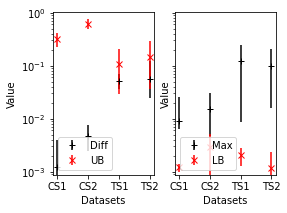

In [57]:
import matplotlib.pyplot as plt

# Upper bounds

actual_UB_mean_list = [
    actual_UB_CS_mean, actual_UB_CS_mean2, actual_UB_TS_mean,
    actual_UB_TS_mean2
]
actual_UB_lower_bounds_list = [
    actual_UB_CS_error[0], actual_UB_CS_error2[0], actual_UB_TS_error[0],
    actual_UB_TS_error2[0]
]
actual_UB_upper_bounds_list = [
    actual_UB_CS_error[1], actual_UB_CS_error2[1], actual_UB_TS_error[1],
    actual_UB_TS_error2[1]
]

UB_mean_list = [UB_CS_mean, UB_CS_mean2, UB_TS_mean, UB_TS_mean2]
UB_lower_bounds_list = [
    UB_CS_error[0], UB_CS_error2[0], UB_TS_error[0], UB_TS_error2[0]
]
UB_upper_bounds_list = [
    UB_CS_error[1], UB_CS_error2[1], UB_TS_error[1], UB_TS_error2[1]
]

# Lower bounds

actual_LB_hT_mean_list = [
    actual_LB_hT_CS_mean, actual_LB_hT_CS_mean2, actual_LB_hT_TS_mean,
    actual_LB_hT_TS_mean2
]
actual_LB_hT_lower_bounds_list = [
    actual_LB_hT_CS_error[0], actual_LB_hT_CS_error2[0],
    actual_LB_hT_TS_error[0], actual_LB_hT_TS_error2[0]
]
actual_LB_hT_upper_bounds_list = [
    actual_LB_hT_CS_error[1], actual_LB_hT_CS_error2[1],
    actual_LB_hT_TS_error[1], actual_LB_hT_TS_error2[1]
]

LB_hT_mean_list = [
    LB_hT_CS_mean, LB_hT_CS_mean2, LB_hT_TS_mean, LB_hT_TS_mean2
]
LB_hT_lower_bounds_list = [
    LB_hT_CS_error[0], LB_hT_CS_error2[0], LB_hT_TS_error[0],
    LB_hT_TS_error2[0]
]
LB_hT_upper_bounds_list = [
    LB_hT_CS_error[1], LB_hT_CS_error2[1], LB_hT_TS_error[1],
    LB_hT_TS_error2[1]
]

# X-axis values (assumed to be sequential integers)
x = ['CS1', 'CS2', 'TS1', 'TS2']

fig, axs = plt.subplots(1, 2, figsize=(4, 3), sharey=True)

# Plot the actual UB with error bars
axs[0].errorbar(
    x,
    actual_UB_mean_list,
    yerr=[actual_UB_lower_bounds_list, actual_UB_upper_bounds_list],
    fmt='+',
    color='black',
    label='Diff')

# Plot the theoretical UB with error bars
axs[0].errorbar(x,
                UB_mean_list,
                yerr=[UB_lower_bounds_list, UB_upper_bounds_list],
                fmt='x',
                color='red',
                label='UB')
# Add labels and title
axs[0].set_xlabel("Datasets")
axs[0].set_ylabel('Value')
axs[0].set_yscale('log')
#axs[0].title('Actual and Theoretical Bounds across different datasets')
axs[0].legend(loc="lower left")

# Plot the actual LB with error bars
axs[1].errorbar(
    x,
    actual_LB_hT_mean_list,
    yerr=[actual_LB_hT_lower_bounds_list, actual_LB_hT_upper_bounds_list],
    fmt='+',
    color='black',
    label='Max')

# Plot the theoretical UB with error bars
axs[1].errorbar(x,
                LB_hT_mean_list,
                yerr=[LB_hT_lower_bounds_list, LB_hT_lower_bounds_list],
                fmt='x',
                color='red',
                label='LB')
# Add labels and title
axs[1].set_xlabel("Datasets")
axs[1].set_ylabel('Value')
axs[1].set_yscale('log')
#axs[0].title('Actual and Theoretical Bounds across different datasets')
axs[1].legend(loc="lower left")

# Show the plot
plt.show()